In [5]:
import os
import numpy as np
import lmfit
import csv
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [6]:
# helper functions

def sinusoid(x, a, b, c):
    return a * np.sin(b * x + c)

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def J(x, y, a, b, c):
    return np.mean((a * np.sin(b*x + c) - y)**2)

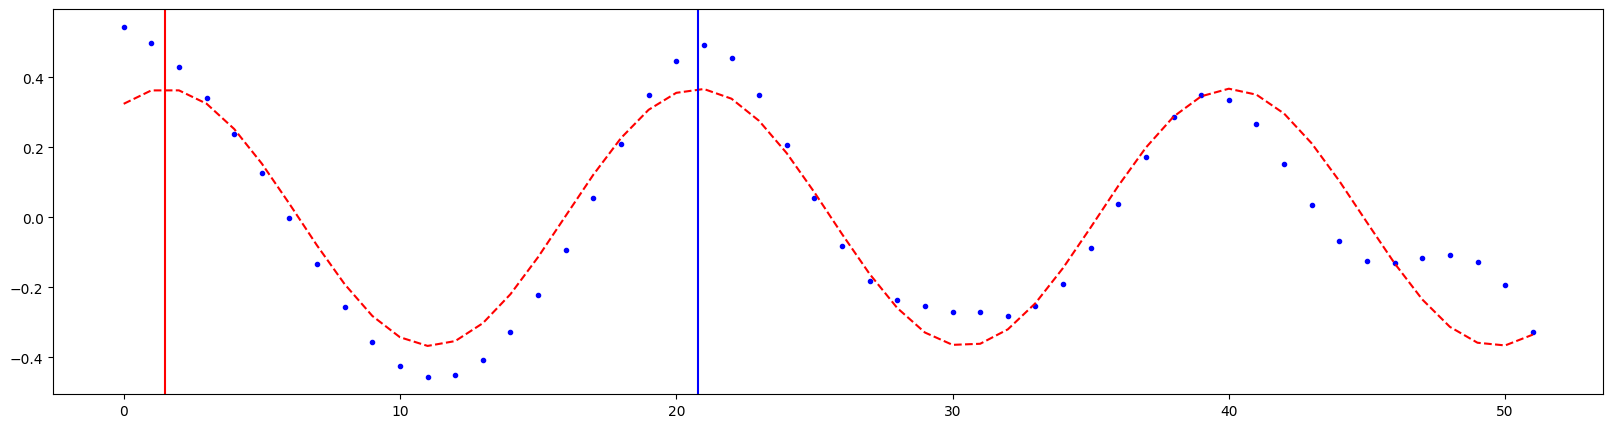

In [9]:
series, num_frames = load_series('..\\time_series\\scale_normalized\\WS-O2-F2-B0-S6-L0-L-0111.csv')
x = np.arange(0, num_frames)
y = savgol_filter(series['left_heel_y'], window_length=11, polyorder=3)

y -= np.mean(y)
y /= (max(y) - min(y))

model = lmfit.models.SineModel()
params = model.guess(y, x)
fit = model.fit(y, params, x=x)

lmfit_amp = fit.params['amplitude'].value
lmfit_omega = fit.params['frequency'].value
lmfit_shift = fit.params['shift'].value
# lmfit_const = fit.params['d'].value

fig = plt.figure(figsize=(20, 5))
plt.plot(x, y, '.', c='b')
plt.plot(x, sinusoid(x, lmfit_amp, lmfit_omega, lmfit_shift), 'r--')

period = 2 * (np.pi) / lmfit_omega

offset = (0.5 * np.pi / float(lmfit_omega)) - (float(lmfit_shift) / float(lmfit_omega))

if (lmfit_amp < 0.0):
    offset -= (np.pi) / (float(lmfit_omega))

while (offset < 0.0): 
    offset += period

while (offset > period):
    offset -= period

plt.axvline(offset, c='r')
plt.axvline(offset + period, c='b')

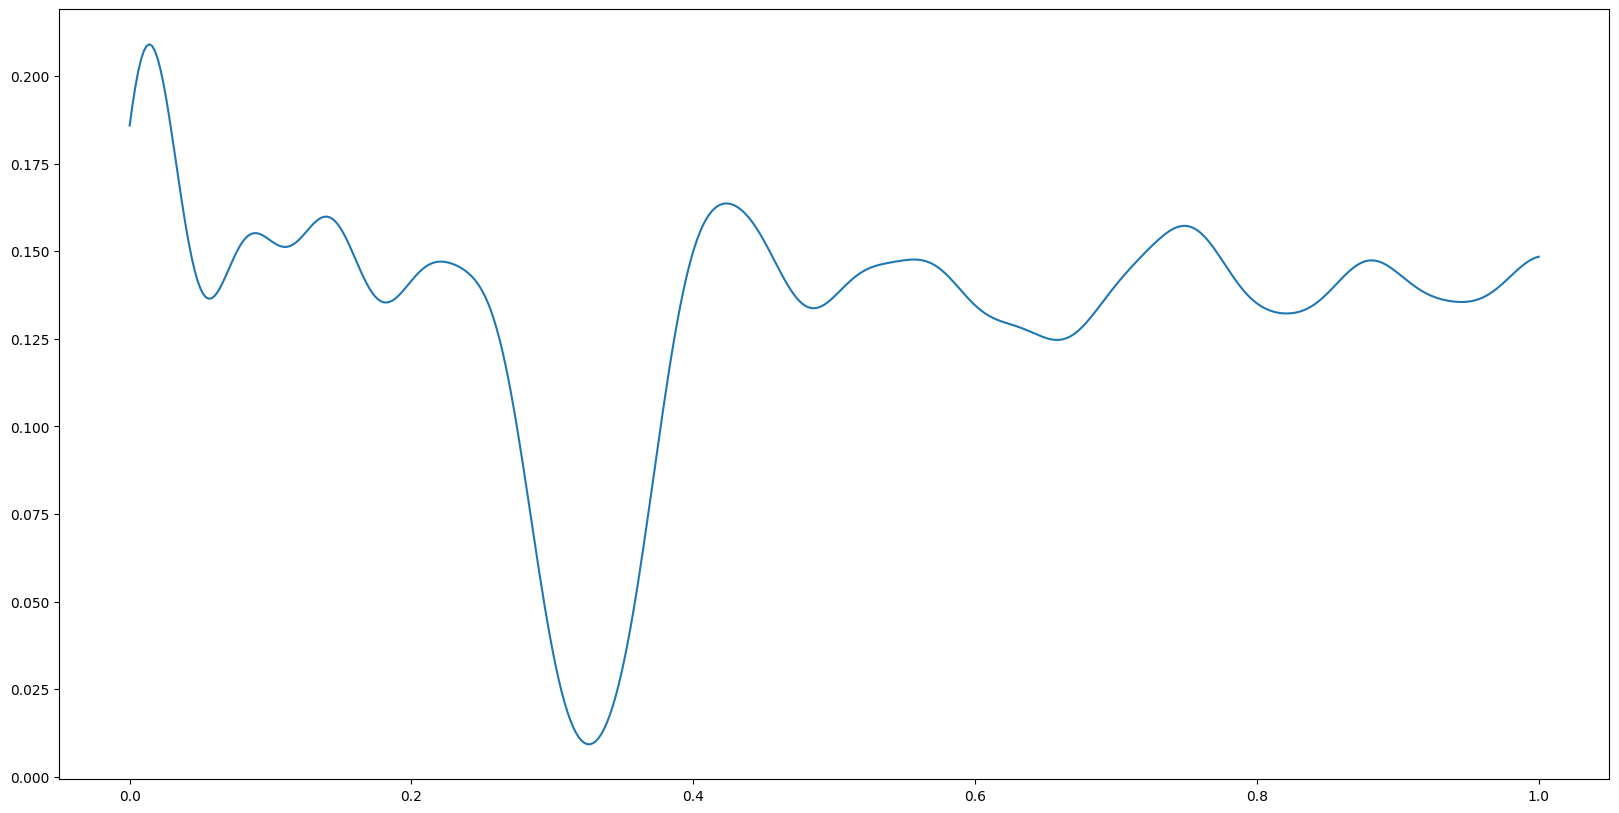

In [10]:
# loss function convexity exploration

period_params = np.linspace(0.0, 1.0, num=500)
shift_params = np.linspace(-2*np.pi, 0, num=500)
errors = []

for period in period_params:
    errors.append(J(x, y, lmfit_amp, period, lmfit_shift))

fig = plt.figure(figsize=(20, 10))
plt.plot(period_params, errors)